Robin Sparticles

    1. Chelsea Owen
    2. Joao Freitas
    3. Dyutideepta Banerjee

In [1]:
import numpy as np
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
plt.rc('font',**{'size':16})

from matplotlib.ticker import NullFormatter
from sklearn import cluster, datasets, mixture #, manifold, TSNE, DBSCAN
from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
%matplotlib inline
np.random.seed(0)

### PART 1

In [2]:
str0 = "t-SNE_310101_d5_R100_e1_N800"
fnamex = "DATA/data_" + str0 + ".dat"

x = np.loadtxt(fnamex)
N = len(x)
print(N)

800


Given $N$ data points, the first 10% belongs to cluster “0” (red), the
next 30% to cluster “1” (green) and the last 60% to cluster “2” (blue).

In [3]:
#separate data
N_red = int(0.1*N)
N_green = int(0.4*N)
N_blue = N
print(N_blue)
#define samples in each
x_red = x[:N_red]
x_green = x[N_red:N_green]
x_blue = x[N_green:N_blue]

800


In [4]:
#define y labels
y_true = np.zeros(N)
for n in range(N_red):
    y_true[n]=0
for n in range(N_red, N_green):
    y_true[n]=1
for n in range(N_green,N):
    y_true[n]=2

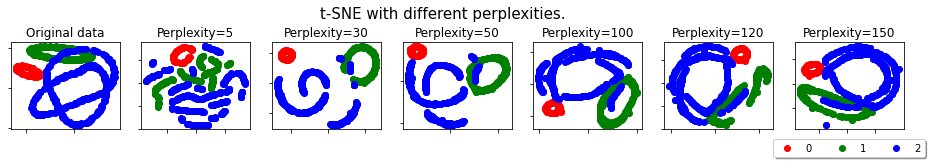

In [5]:
(fig, subplots) = plt.subplots(1, 7, figsize=(16, 2))
perplexities = [5, 30, 50, 100, 120, 150]

ax = subplots[0]
ax.set_title("Original data")
ax.scatter(x_red[:,0], x_red[:,1], c="r")
ax.scatter(x_green[:,0], x_green[:,1], c="g")
ax.scatter(x_blue[:,0], x_blue[:,1], c="b")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

for i, perplexity in enumerate(perplexities):
    ax = subplots[i+1]

    tsne = TSNE(n_components=2, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(x)
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:N_red][:,0], Y[:N_red][:,1], c="r", label='0')
    ax.scatter(Y[N_red:N_green][:,0], Y[N_red:N_green][:,1], c="g", label='1')
    ax.scatter(Y[N_green:N_blue][:,0], Y[N_green:N_blue][:,1], c="b", label='2')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    fig.suptitle('t-SNE with different perplexities.', size=15)
    fig.subplots_adjust(top=0.73)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),shadow=True, ncol=3)
plt.show()

C:\Users\chels\OneDrive\Documents\New folder\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
C:\Users\chels\OneDrive\Documents\New folder\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


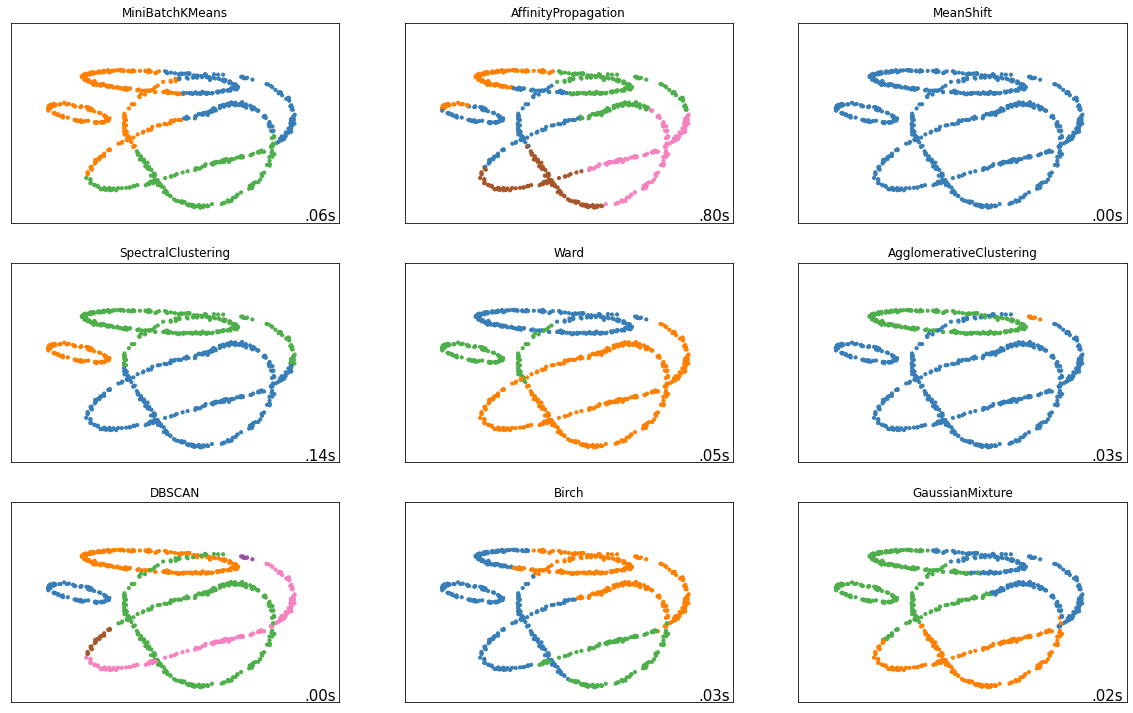

In [6]:
#clustering code from notebook
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(20, 12.5))
#plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
#                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}


    # update parameters with dataset-specific values
params = default_base.copy()
#params.update(algo_params)


# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(x)

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(x, quantile=params['quantile'])

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    X, n_neighbors=params['n_neighbors'], include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# ============
# Create cluster objects
# ============
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
ward = cluster.AgglomerativeClustering(
    n_clusters=params['n_clusters'], linkage='ward',
    connectivity=connectivity)
spectral = cluster.SpectralClustering(
    n_clusters=params['n_clusters'], eigen_solver='arpack',
    affinity="nearest_neighbors")
dbscan = cluster.DBSCAN(eps=params['eps'])
affinity_propagation = cluster.AffinityPropagation(
    damping=params['damping'], preference=params['preference'])
average_linkage = cluster.AgglomerativeClustering(
    linkage="average", affinity="cityblock",
    n_clusters=params['n_clusters'], connectivity=connectivity)
birch = cluster.Birch(n_clusters=params['n_clusters'])
gmm = mixture.GaussianMixture(
    n_components=params['n_clusters'], covariance_type='full')
    
clustering_algorithms = (
    ('MiniBatchKMeans', two_means),
    ('AffinityPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('Birch', birch),
    ('GaussianMixture', gmm)
    )

for name, algorithm in clustering_algorithms:
    t0 = time.time()

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
                "ignore",
            message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
            category=UserWarning)
        algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)
        
    plt.subplot(3, 3, plot_num)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
    
    plt.title(name)
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
    plot_num += 1

plt.show()

In [7]:
#to find good eps value
def find_1st_neighbour(i, data):
    least_distance = 0
    for j in range(len(data)):
        distance = np.linalg.norm(data[i] - data[j])
        if distance == 0:
            continue
        elif least_distance == 0:
            least_distance = distance
        elif distance < least_distance:
            least_distance = distance
    
    return least_distance

#X = StandardScaler().fit_transform(x)
least_distances = np.array([find_1st_neighbour(i[0], x) for i in enumerate(X)])

epsilon = 4800

Text(0, 0.5, 'Counts')

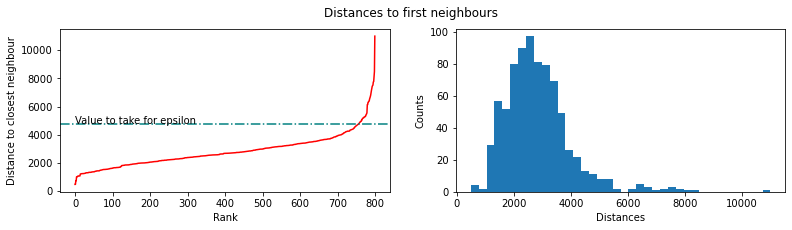

In [8]:
least_distances.sort()

fig, axs = plt.subplots(1, 2, figsize=(13,3))

fig.suptitle("Distances to first neighbours")
axs[0].plot(least_distances, c='r')
axs[0].axhline(y=epsilon, color='teal', linestyle='-.')
axs[0].text(0,epsilon+0.01,"Value to take for epsilon")
axs[0].set_xlabel("Rank")
axs[0].set_ylabel("Distance to closest neighbour")

axs[1].hist(least_distances, bins = 'fd')
axs[1].set_xlabel("Distances")
axs[1].set_ylabel("Counts")

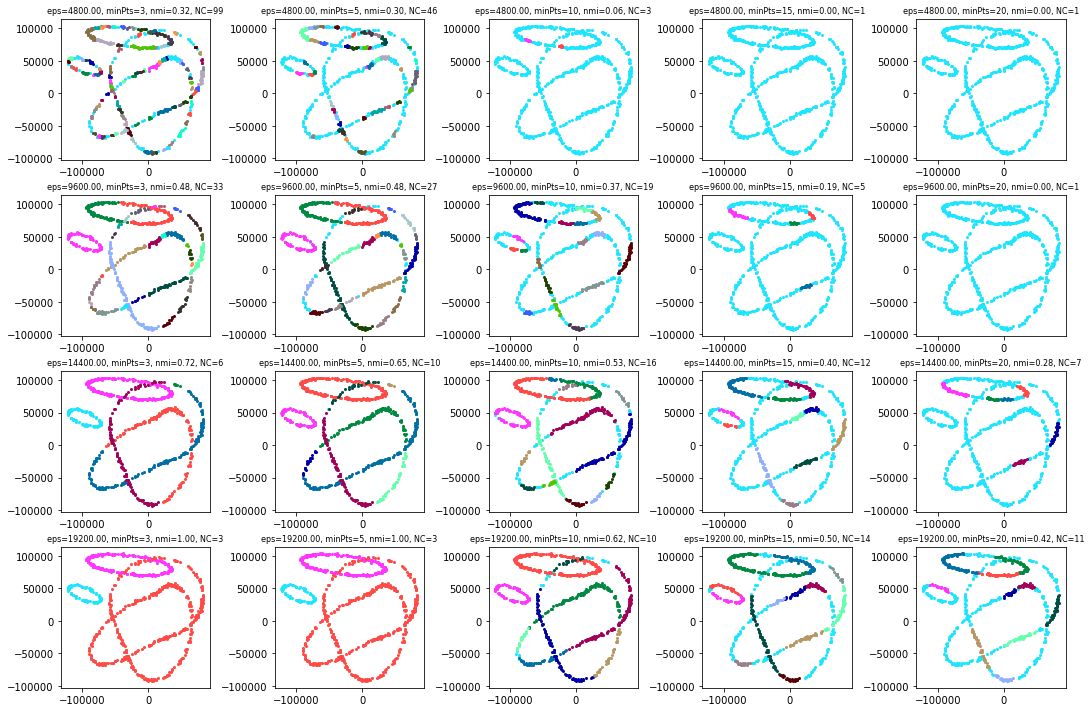

In [9]:
def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=4)

from collections import OrderedDict

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)
# Note that this deals with the label permutation problem
       
cpalette = ["#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(0)
#X = StandardScaler().fit_transform(x)

eps_range = [epsilon, 2*epsilon, 3*epsilon, 4*epsilon]
min_sample_range = [3, 5, 10, 15, 20]
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,10))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = cluster.DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(x)
        y = model.labels_
        plotting_ax(x,y,ax[i,j])
        nmi=NMI(y_true, y)
        ax[i,j].set_title('eps=%.2f, minPts=%i, nmi=%.2f, NC=%d'%(eps,min_samples,nmi, len(set(y))), fontsize=8)
plt.tight_layout(h_pad=0.5)
plt.show()

DBSCAN is able to effectively cluster the data with 100% accuracy. 

### PART 2

In [10]:
str0 = "M5_N400"
fnamex = "DATA/x_" + str0 + ".csv"
fnamey = "DATA/y_" + str0 + ".csv"

xx = np.loadtxt(fnamex, delimiter=' ')
N = len(xx)
print(N)
y = np.loadtxt(fnamey, delimiter=' ')

400


In [11]:
#separate data
#dont need to do this 
xx_0 = [xx[n] for n in range(N-1) if y[n]==0]
xx_1 = [xx[n] for n in range(N-1) if y[n]==1]
xx_2 = [xx[n] for n in range(N-1) if y[n]==2]
xx_3 = [xx[n] for n in range(N-1) if y[n]==3]

In [12]:
#get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(xx)
tsne_result.shape

(400, 2)

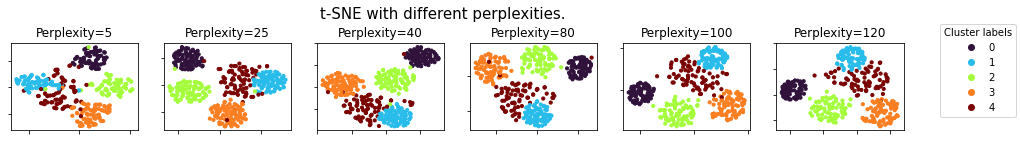

In [13]:
# from matplotlib.colors import ListedColormap
# cmap = ListedColormap(cpalette)
labels = [0,1,2,3,4]
(fig, subplots) = plt.subplots(1, 6, figsize=(16, 2))
perplexities = [5, 25, 40, 80, 100, 120]

for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    tsne = TSNE(n_components=2, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(xx)
    ax.set_title("Perplexity=%d" % perplexity)
    scatter = ax.scatter(Y[:,0], Y[:,1], c=y, cmap='turbo',s=10)#, label=y)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    handles, _ = scatter.legend_elements(prop='colors')
    fig.suptitle('t-SNE with different perplexities.', size=15)
    fig.subplots_adjust(top=0.73)
fig.legend(handles, labels, loc='center right', title='Cluster labels')
plt.show()

These are the patterns for each cluster label. y=0 is the easiest to distinguish as it has the most complex pattern whereas y=4 has the least complex so it is the hardest to distinguish. Half of the numbers (4) in the y=4 pattern are present in the y=1 group, hence why they are difficult to distinguish from each other.
```
if y[n]==0:
        x[n] = pattern(x[n],[3,4,14,16,22,25,27,32],[0,5,7,9,12,15,26,30])
    elif y[n]==1:
        x[n] = pattern(x[n],[0,11,12,23,24,28,33],[2,4,6,25,26,30,31])
    elif y[n]==2:
        x[n] = pattern(x[n],[0,5,8,15,19,34],[5,9,10,15,26,29])
    elif y[n]==3:
        x[n] = pattern(x[n],[6,7,16,24,26],[3,5,13,16,27])
    elif y[n]==4:
        x[n] = pattern(x[n],[5,12,22,28],[4,5,30,34])
```            

In [14]:
#find distances for eps, to quantify distance between sequences, use the number of different bits aka hamming distance

from scipy.spatial.distance import hamming
def hamming_dist(i, data):
    least_distance = 0
    for j in range(len(data)):
        distance = hamming(xx[i],xx[j])*len(xx[i])
        if distance == 0:
            continue
        elif least_distance == 0:
            least_distance = distance
        elif distance < least_distance:
            least_distance = distance
    
    return least_distance

In [15]:
least_distances_2 = np.array([hamming_dist(i[0], xx) for i in enumerate(xx)])

Text(0, 0.5, 'Counts')

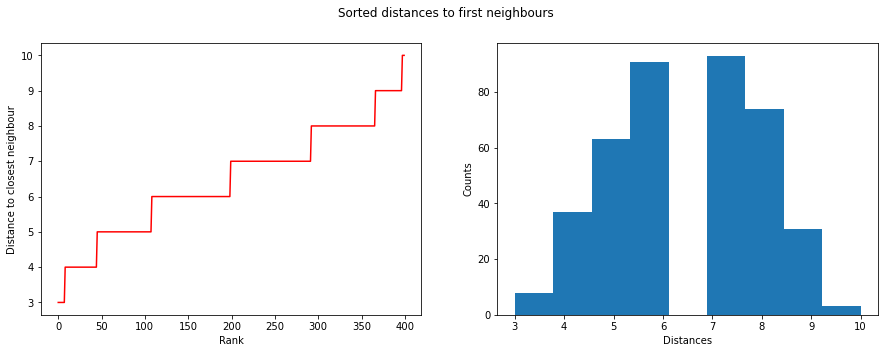

In [16]:
least_distances_2.sort()

fig, axs = plt.subplots(1, 2, figsize = (15, 5))
fig.suptitle("Sorted distances to first neighbours")

axs[0].plot(least_distances_2, c='r')
axs[0].set_xlabel("Rank")
axs[0].set_ylabel("Distance to closest neighbour")

axs[1].hist(least_distances_2, bins = 'fd')
axs[1].set_xlabel('Distances')
axs[1].set_ylabel('Counts')

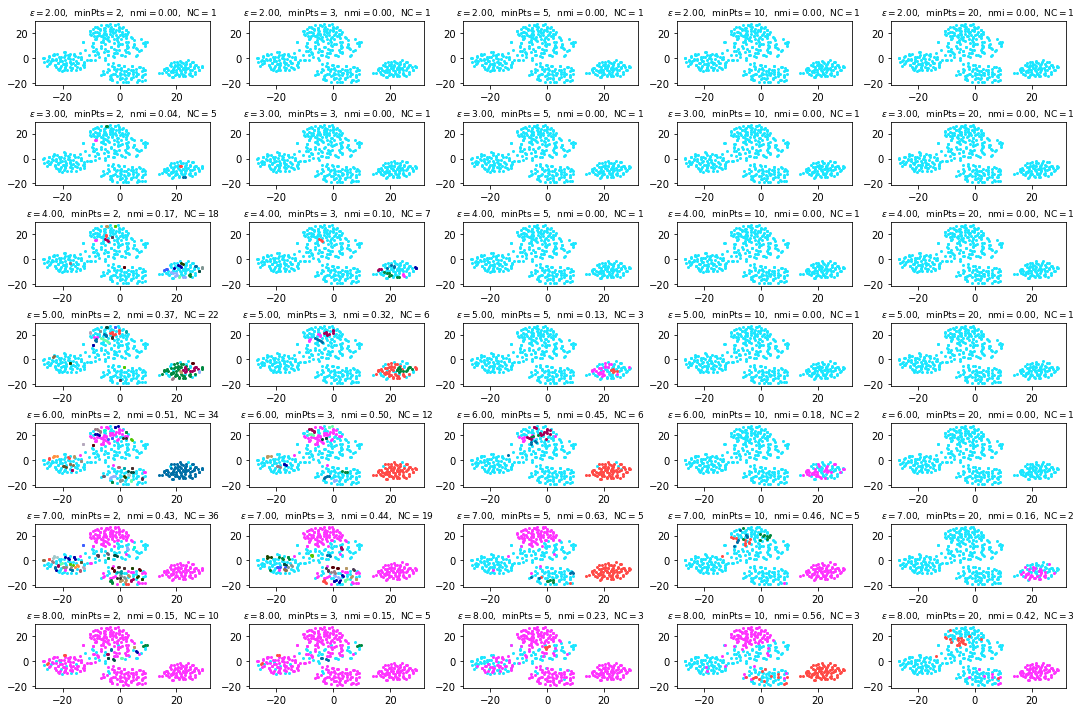

In [17]:
#X = StandardScaler().fit_transform(xx)

epsilon = np.mean(least_distances_2)
eps_range = [2,3,4,5,6,7,8] 
min_sample_range = [2, 3, 5, 10, 20]
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,10))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = cluster.DBSCAN(eps=eps, min_samples=min_samples, metric='l1')
        model.fit(xx)
        yy = model.labels_
        #print(len(set(y)))
        plotting_ax(tsne_result,yy,ax[i,j]) #plot 2D tsne output 
        nmi=NMI(y, yy)
        ax[i,j].set_title('$\epsilon=%.2f$,  minPts$=%i$,  nmi$=%.2f$,  NC$= %d$'%(eps,min_samples,nmi, len(set(yy))), fontsize=9)
plt.tight_layout(h_pad=0.5)
plt.show()

max accuracy is only around $50\%$. t-SNE works a lot better than DBSCAN on this second set of data. 

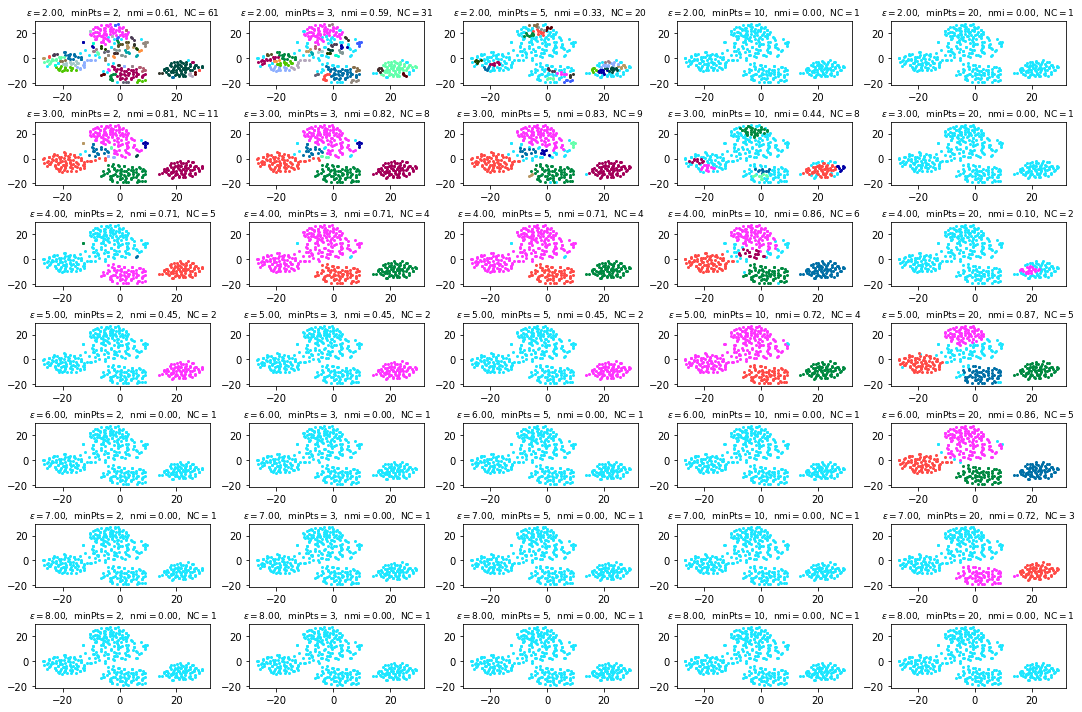

In [18]:
#apply DBSCAN to the t-sne data
#X = StandardScaler().fit_transform(tsne_result)

eps_range = [2,3,4,5,6,7,8] 
min_sample_range = [2, 3, 5, 10, 20]
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,10))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = cluster.DBSCAN(eps=eps, min_samples=min_samples, metric='l1')
        model.fit(tsne_result)
        yy = model.labels_
        plotting_ax(tsne_result,yy,ax[i,j]) #plot 2D tsne output 
        nmi= NMI(y, yy)
        ax[i,j].set_title('$\epsilon=%.2f$,  minPts$=%i$,  nmi$=%.2f$,  NC$= %d$'%(eps,min_samples,nmi, len(set(yy))), fontsize=9)
plt.tight_layout(h_pad=0.5)
plt.show()

This approach has a much better higher accuracy: nmi $= 0.87$ with $\epsilon=5$, minPts $= 20$. 

t-SNE works better on this data than DBSCAN. Potentially this is because the $y=1$ and $y=4$ groups are close together and DBSCAN expects a density drop between groups that it uses to detect the borders of the cluster. Additionally, if there are differences in densities between clusters, DBSCAN cannot adjust so will lead to errors. t-SNE does not preserve distances nor density so this could be why it has better success on grouping the 36-bit data. 